<a href="https://colab.research.google.com/github/BarkinTopcu/company_forecasting/blob/main/Daily_Weekly_Monthly_Sales_Forecasting_without_Store_Focusing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Sales Forecasting with AI Based
This code documentation and code is written by Recep Barkın Topcu.

The dataset is taken from kaggle: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

This code just focus on the company transaction without store based. All sales of the all stores at each day are gathered together.

In [1]:
pip install modin[ray] -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.7 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#modin pandas is faster than pandas
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [4]:
#Dask is used for reading the csv. When I was using pandas in the other projects sometimes pandas cannot read all of the data. For that reason I prefer to use dask.
sales_df = dd.read_csv("transactions.csv")
sales_df = sales_df.compute()
sales_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


# Data Preprocessing

In [5]:
sales_df.drop(index=0,inplace=True) #There is only one sales info at 2013-01-01. I am deleting this data because of that.
sales_df["date"] = pd.to_datetime(sales_df["date"]) #Converting date column to datetime format

In [6]:
#Gathering all transactions of the all stores for each day.
sales_df = sales_df.groupby("date",as_index=False).agg({"transactions":"sum"})
sales_df

,date,transactions
0,2013-01-02,93215
1,2013-01-03,78504
2,2013-01-04,78494
3,2013-01-05,93573
4,2013-01-06,90464
...,...,...
1676,2017-08-11,89551
1677,2017-08-12,89927
1678,2017-08-13,85993
1679,2017-08-14,85448


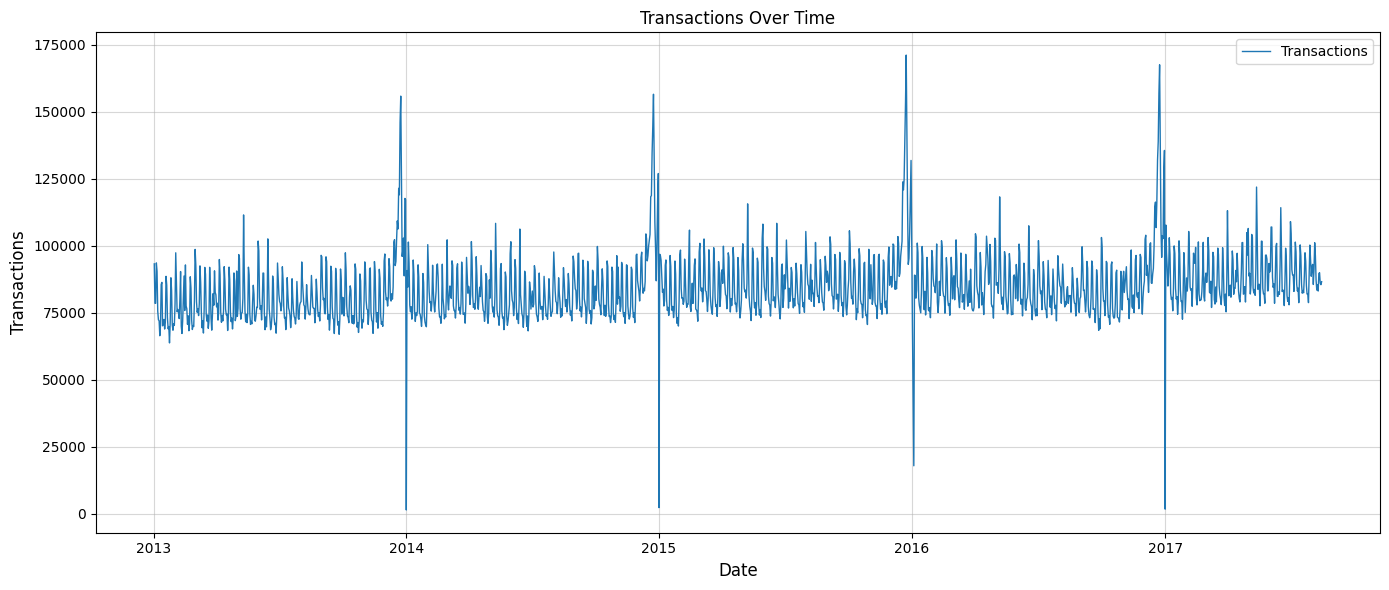

In [7]:
#Ploting the dataframe
plt.figure(figsize=(14,6))
plt.plot(sales_df["date"],sales_df["transactions"],label="Transactions",linewidth=1)
plt.title("Transactions Over Time", fontsize=12)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Transactions",fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Forecasting with Different Methods

## Basic Type Methods

### Moving Average
This is a basic method for forecasting.

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
sales_moving = sales_df.copy()
#Creating two different moving average with 30 days and 7 days
sales_moving['moving_average_30'] = sales_moving['transactions'].rolling(window=30).mean()
sales_moving['moving_average_7'] = sales_moving['transactions'].rolling(window=7).mean()

In [9]:
#The first 29 day have NaN values because of the rolling.
y_pred = sales_moving['moving_average_30'].dropna()
y_true = sales_moving['transactions'][len(sales_moving) - len(y_pred):]

In [10]:
#Using 3 different metrics to evaluate method.
r2_mov = r2_score(y_true, y_pred)
rmse_mov = np.sqrt(mean_squared_error(y_true, y_pred))
mape_mov = mean_absolute_percentage_error(y_true, y_pred)
print(f"R^2 is {r2_mov} \n RMSE is {rmse_mov} \n MAPE is {mape_mov}")

R^2 is 0.13794754841146717 
 RMSE is 11245.957606265532 
 MAPE is 0.19658746855881928


In [11]:
#Creating a new dataframe to compare the methods in the end.
result_data = {"Method":["Moving Average - 30"],
               "R^2":[r2_mov],
               "RMSE":[rmse_mov],
               "MAPE":[mape_mov]}
results_df = pd.DataFrame(data=result_data)
results_df

2025-01-27 00:03:17,044	INFO worker.py:1841 -- Started a local Ray instance.


,Method,R^2,RMSE,MAPE
0,Moving Average - 30,0.137948,11245.957606,0.196587


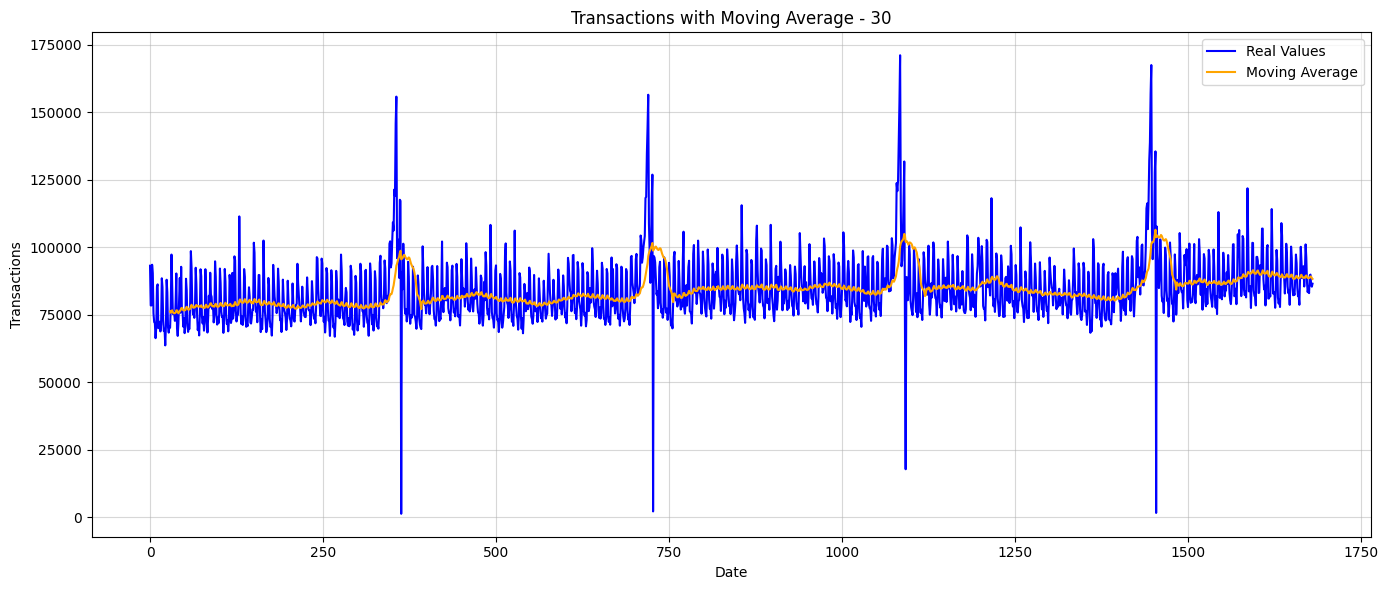

In [12]:
#Ploting the real data
plt.figure(figsize=(14, 6))
plt.plot(sales_moving.index, sales_moving['transactions'], label='Real Values', color='blue')
plt.plot(sales_moving.index, sales_moving['moving_average_30'], label='Moving Average', color='orange')
plt.title('Transactions with Moving Average - 30')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
#Similar thing with 7 days
y_pred = sales_moving['moving_average_7'].dropna()
y_true = sales_moving['transactions'][len(sales_moving) - len(y_pred):]
#Using 3 different metrics to evaluate method.
r2_mov = r2_score(y_true, y_pred)
rmse_mov = np.sqrt(mean_squared_error(y_true, y_pred))
mape_mov = mean_absolute_percentage_error(y_true, y_pred)
print(f"R^2 is {r2_mov} \n RMSE is {rmse_mov} \n MAPE is {mape_mov}")
result_data = {"Method":["Moving Average - 7"],
               "R^2":[r2_mov],
               "RMSE":[rmse_mov],
               "MAPE":[mape_mov]}
results_df = pd.concat([results_df, pd.DataFrame(result_data)], ignore_index=True)
results_df

R^2 is 0.33711855991085937 
 RMSE is 9864.605200518448 
 MAPE is 0.18279177922105586


,Method,R^2,RMSE,MAPE
0,Moving Average - 30,0.137948,11245.957606,0.196587
1,Moving Average - 7,0.337119,9864.605201,0.182792


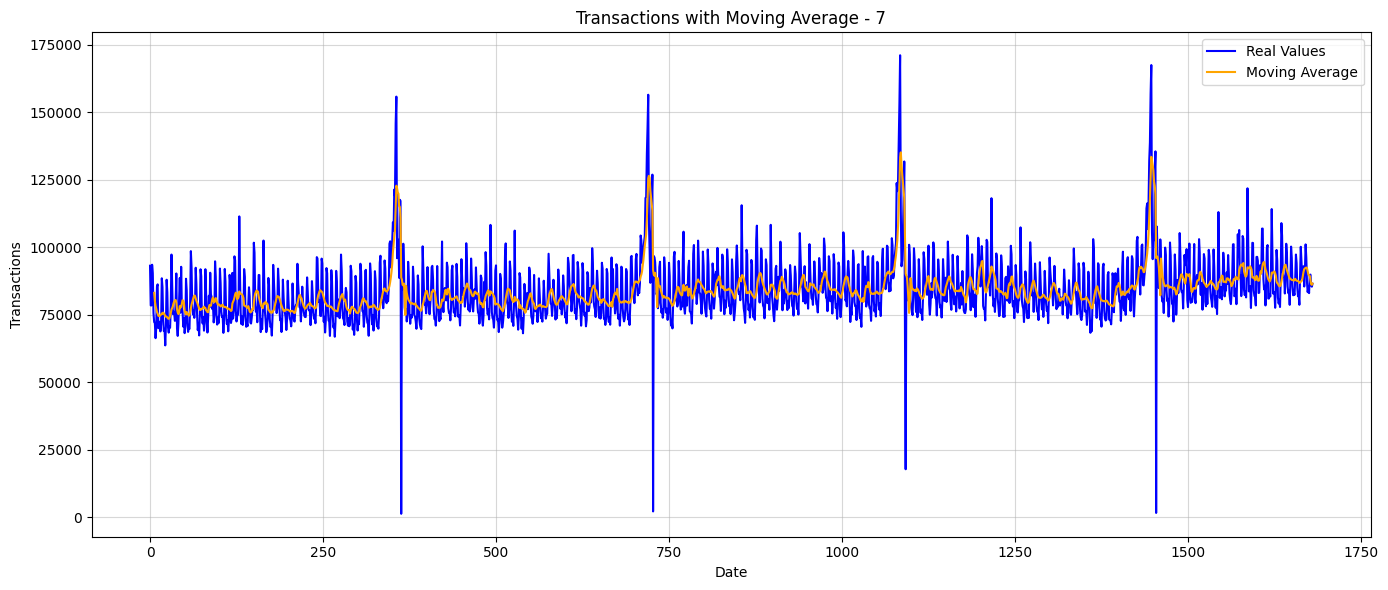

In [15]:
#Ploting the real data vs predicted
plt.figure(figsize=(14, 6))
plt.plot(sales_moving.index, sales_moving['transactions'], label='Real Values', color='blue')
plt.plot(sales_moving.index, sales_moving['moving_average_7'], label='Moving Average', color='orange')
plt.title('Transactions with Moving Average - 7')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Yeni Bölüm